In [1]:
import os
import sys

In [3]:
home_directory = os.path.expanduser('~')
nn_library_path = home_directory + '/Documents/HarveyMuddWork/Neural_Nets_Research/neural_nets_research/neural_nets_library'
sys.path.append(nn_library_path)

In [4]:
from training import train_model_with_validation, exp_lr_scheduler, split_dataset
from dataset import AdvancedImageFolder, greyscale_image_loader, tightest_image_crop, square_padding
from net_architectures import ResidualNet

import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
resnet_sanborn_digit = ResidualNet(1, 32, 32, 3, 10)
resnet_sanborn_digit = nn.DataParallel(resnet_sanborn_digit.cuda())

In [6]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(tightest_image_crop),
        transforms.Lambda(square_padding),
        transforms.ToPILImage(),
        transforms.Resize(32),
        transforms.ToTensor()
    ])

In [16]:
dset_sanborn_digits = AdvancedImageFolder('/media/mehdi2277/MyFiles/large_datasets/text_classification/SanbornDigits', transform, loader = greyscale_image_loader,
                                          filter_fn = lambda p: p[1] < 10, shuffle = True)
loader_digit_train, loader_digit_test, loader_digit_validation = split_dataset(dset_sanborn_digits, thread_count=8, batch_size=128)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer_digit = optim.SGD(resnet_sanborn_digit.parameters(), lr=0.001, momentum=0.9)

In [10]:
resnet_sanborn_digit = train_model_with_validation(resnet_sanborn_digit, loader_digit_train, 
                                                   loader_digit_validation, criterion, 
                                                   optimizer_digit, exp_lr_scheduler)

Epoch 0/19
----------
LR is set to 0.001
Epoch Number: 0, Validation Accuracy: 0.9246

Epoch 1/19
----------
Epoch Number: 1, Validation Accuracy: 0.9504

Epoch 2/19
----------
Epoch Number: 2, Validation Accuracy: 0.9559

Epoch 3/19
----------
Epoch Number: 3, Validation Accuracy: 0.9592

Epoch 4/19
----------
Epoch Number: 4, Validation Accuracy: 0.9605

Epoch 5/19
----------
Epoch Number: 5, Validation Accuracy: 0.9622

Epoch 6/19
----------
Epoch Number: 6, Validation Accuracy: 0.9639

Epoch 7/19
----------
LR is set to 0.0001
Epoch Number: 7, Validation Accuracy: 0.9639

Epoch 8/19
----------
Epoch Number: 8, Validation Accuracy: 0.9637

Epoch 9/19
----------
Epoch Number: 9, Validation Accuracy: 0.9641

Epoch 10/19
----------
Epoch Number: 10, Validation Accuracy: 0.9641

Epoch 11/19
----------
Epoch Number: 11, Validation Accuracy: 0.9643

Epoch 12/19
----------
Epoch Number: 12, Validation Accuracy: 0.9637

Epoch 13/19
----------
Epoch Number: 13, Validation Accuracy: 0.9645

E

In [18]:
print(test_model(resnet_sanborn_digit, loader_digit_test))

0.9702280405405406


In [11]:
torch.save(resnet_sanborn_digit.module.state_dict(), 'rad_hmc_2018/src/OCR/models/sanborn_digit_model.pth')

In [12]:
digits = list(range(10))

In [13]:
def categoryFromOutput(output):
    _, category_i = output.data.max(1) # Tensor out of Variable with .data
    return category_i

def categoryAndProb(output):
    top_value, category_i = output.data.max(1) # Tensor out of Variable with .data
    return top_value, category_i

def confusion_matrix(model, data_loader, all_categories):
    n_categories = len(all_categories)
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
   
    for inputs, labels in data_loader:
        inputs = Variable(inputs.cuda())
        output = model(inputs)
        
        guesses = categoryFromOutput(output)
        
        for category_i, guess_i in zip(labels, guesses):
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure(figsize = (16,16), dpi = 160)
    ax = fig.add_subplot(111)
    print(confusion)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()
    
def accuracy_for_each_category(model, data_loader, all_categories):
    n_categories = len(all_categories)
    
    # Keep track of guesses
    number_of_corrects = torch.zeros(n_categories)
    number_of_appearances = torch.zeros(n_categories)
    
    for inputs, labels in data_loader:
        inputs = Variable(inputs.cuda())
        output = model(inputs)
        
        guesses = categoryFromOutput(output)
        
        for category_i, guess_i in zip(labels, guesses):
            if category_i == guess_i:
                number_of_corrects[category_i] += 1
            
            number_of_appearances[category_i] += 1
        
    accuracies = number_of_corrects / number_of_appearances
    
    return dict(zip(all_categories, accuracies))


 0.9856  0.0000  0.0000  0.0000  0.0014  0.0029  0.0072  0.0000  0.0014  0.0014
 0.0000  0.9972  0.0000  0.0000  0.0000  0.0000  0.0000  0.0028  0.0000  0.0000
 0.0000  0.0000  0.9853  0.0016  0.0000  0.0000  0.0016  0.0098  0.0000  0.0016
 0.0031  0.0000  0.0031  0.9832  0.0000  0.0015  0.0015  0.0000  0.0031  0.0046
 0.0080  0.0016  0.0000  0.0000  0.9824  0.0000  0.0016  0.0000  0.0016  0.0048
 0.0015  0.0000  0.0000  0.0015  0.0015  0.9912  0.0029  0.0015  0.0000  0.0000
 0.0025  0.0000  0.0000  0.0000  0.0000  0.0013  0.9937  0.0000  0.0025  0.0000
 0.0014  0.0029  0.0057  0.0000  0.0000  0.0000  0.0000  0.9900  0.0000  0.0000
 0.0022  0.0022  0.0000  0.0043  0.0000  0.0000  0.0152  0.0000  0.9719  0.0043
 0.0000  0.0000  0.0000  0.0042  0.0042  0.0056  0.0000  0.0000  0.0069  0.9792
[torch.FloatTensor of size 10x10]



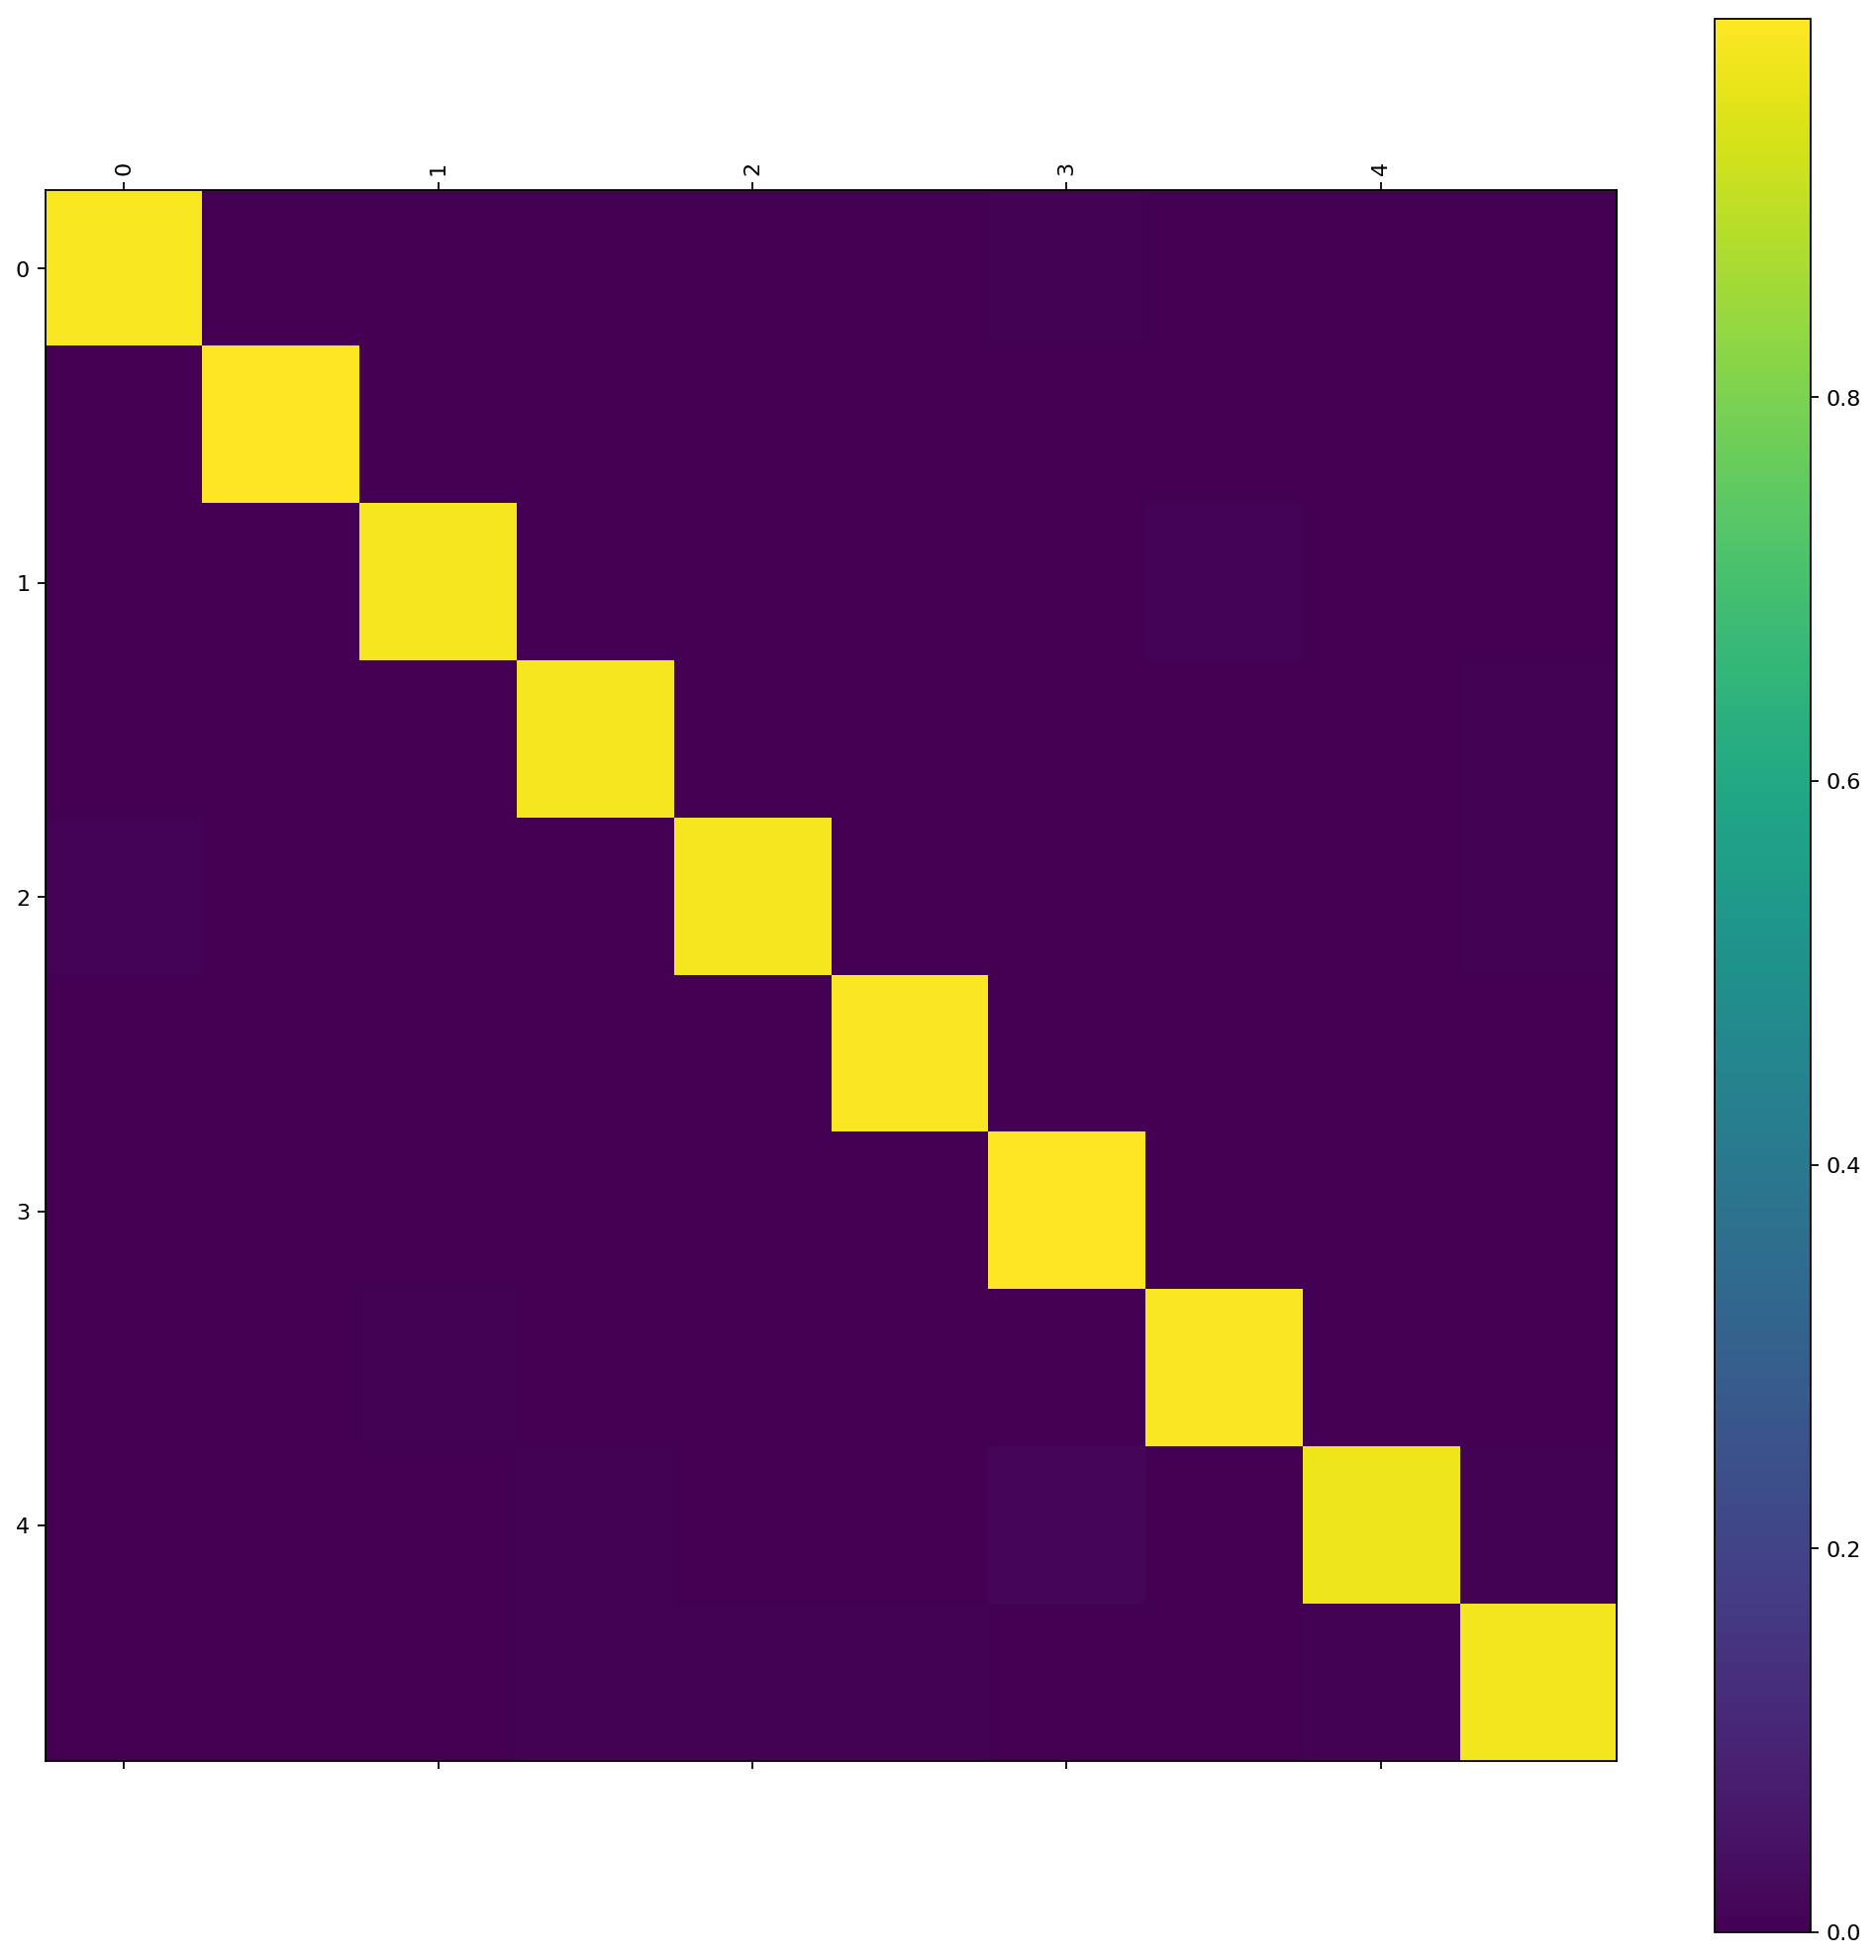

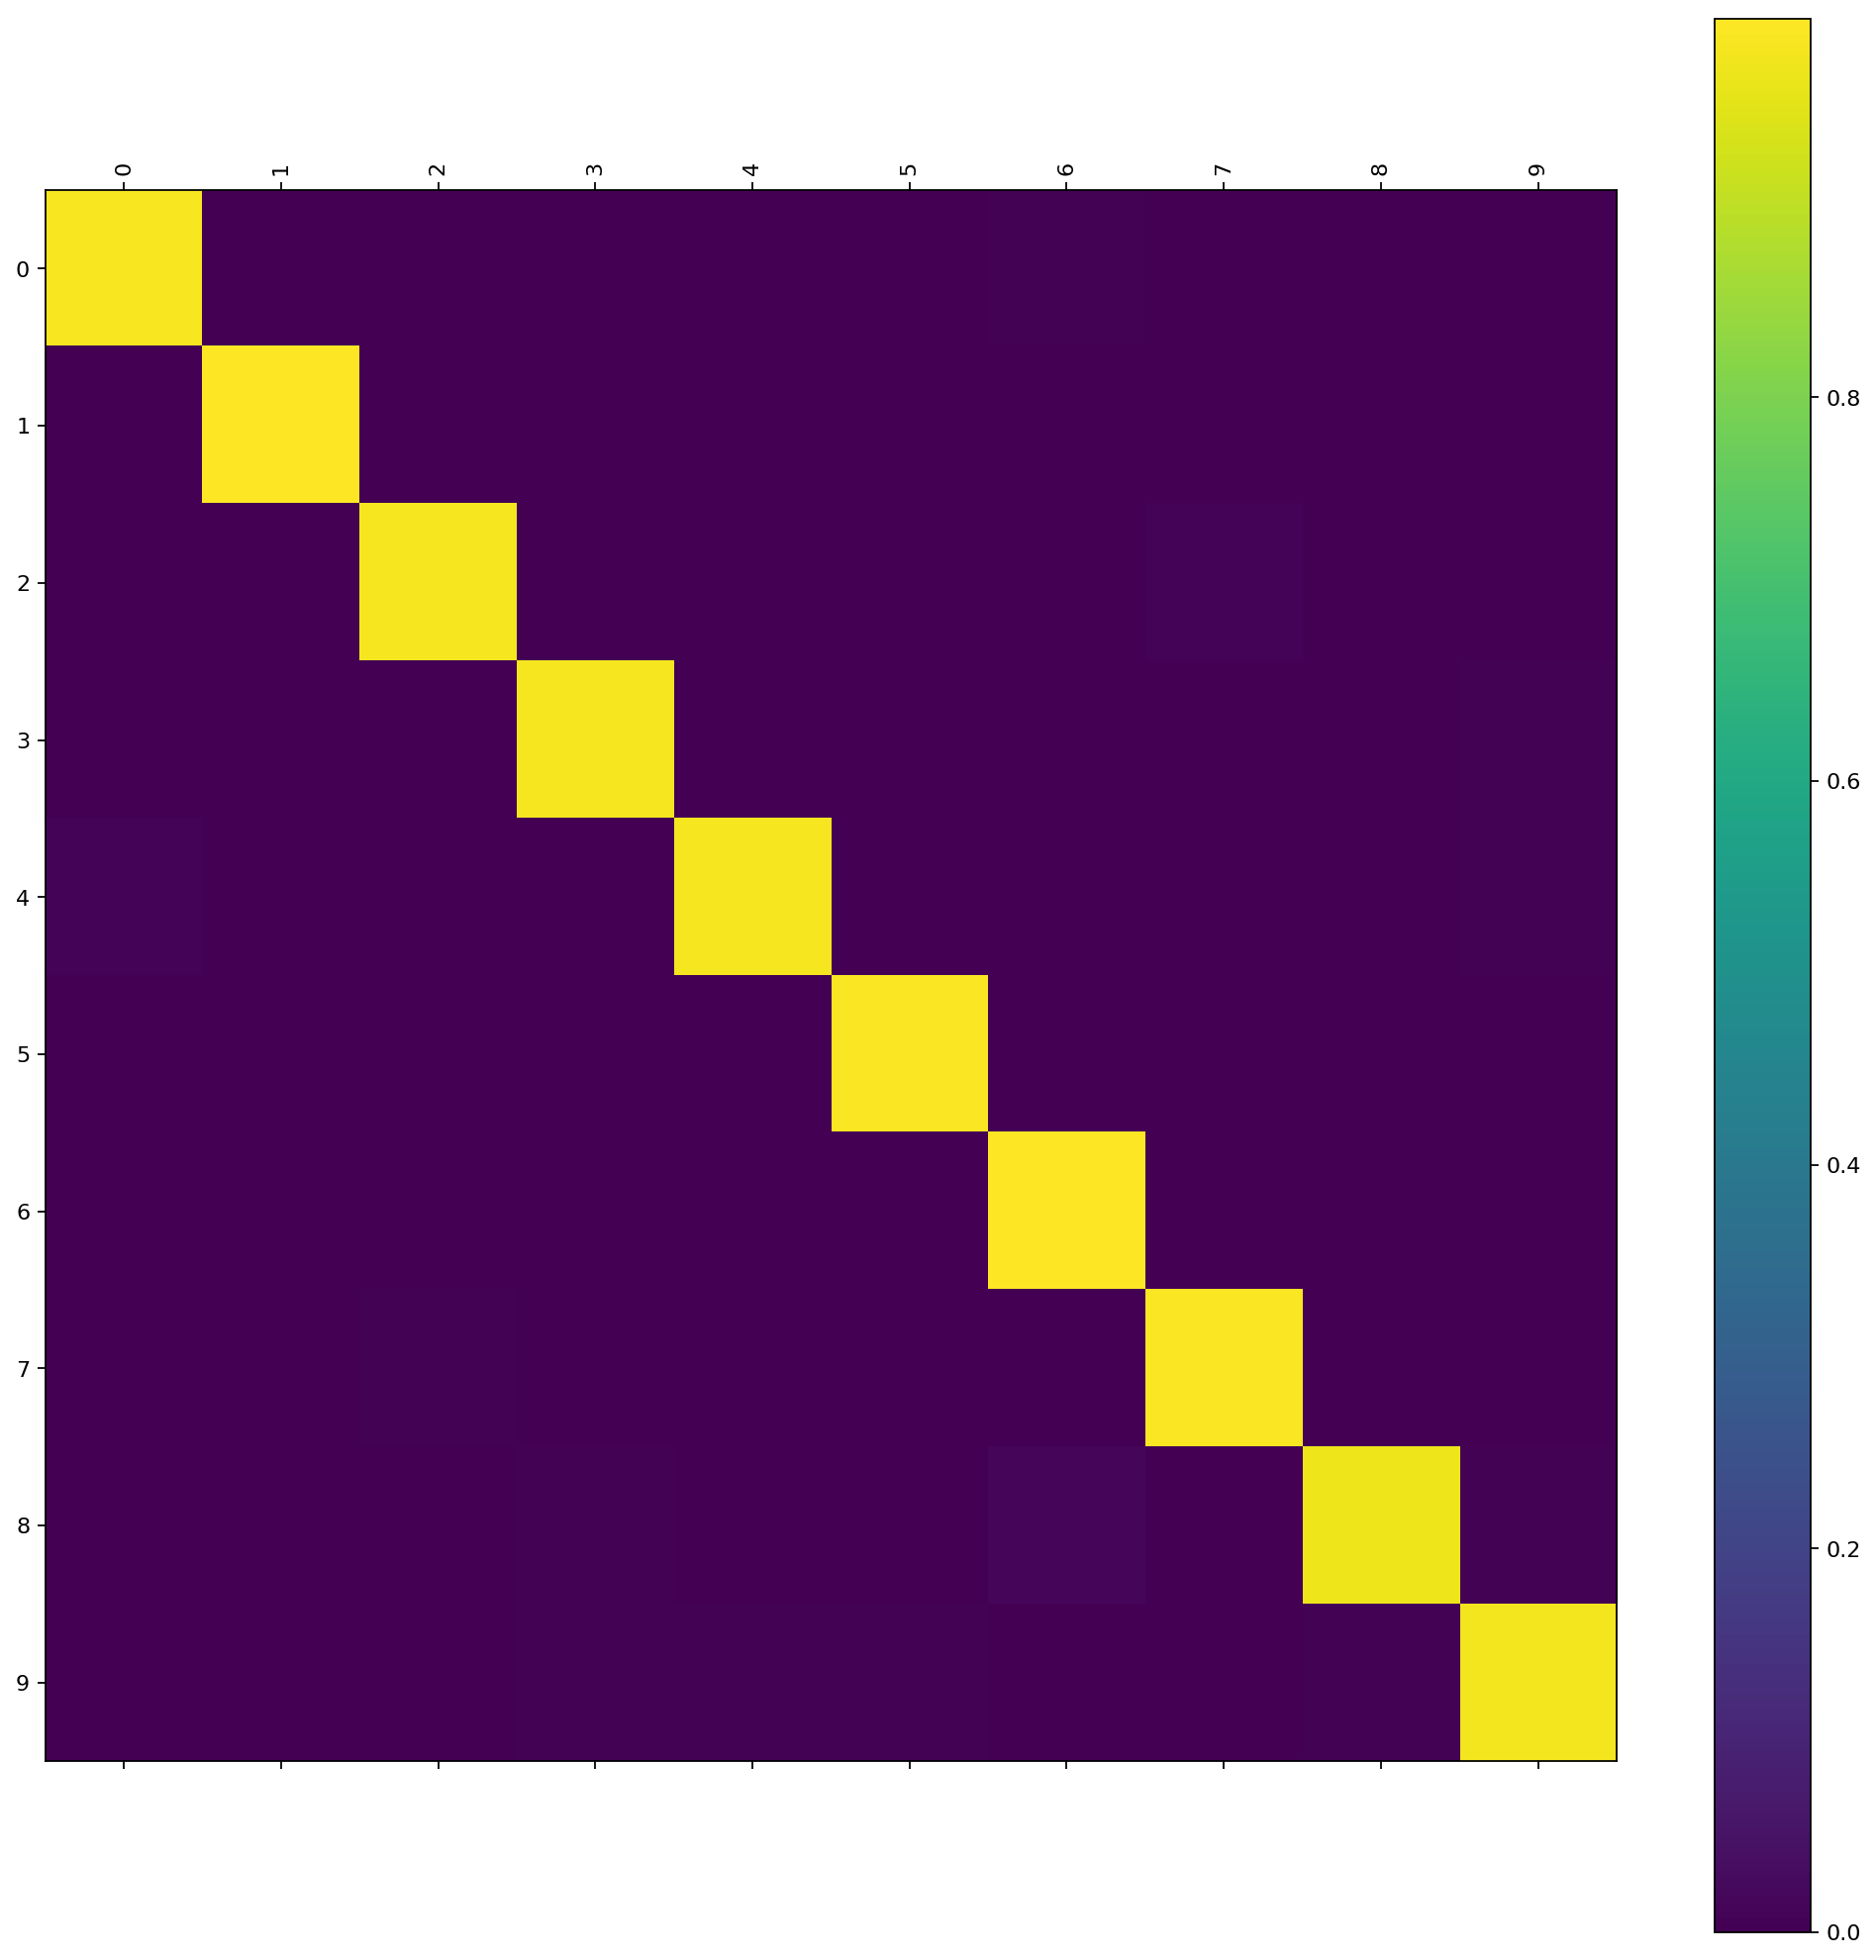

In [19]:
confusion_matrix(resnet_sanborn_digit, loader_digit_test, digits)

In [20]:
accuracy_dict = accuracy_for_each_category(resnet_sanborn_digit, loader_digit_test, digits)

In [21]:
for symbol, accuracy in sorted(accuracy_dict.items(), key = lambda p: p[1]):
    print('Symbol: {}, Acc: {:.4f}'.format(symbol, accuracy))

Symbol: 8, Acc: 0.9719
Symbol: 9, Acc: 0.9792
Symbol: 4, Acc: 0.9824
Symbol: 3, Acc: 0.9832
Symbol: 2, Acc: 0.9853
Symbol: 0, Acc: 0.9856
Symbol: 7, Acc: 0.9900
Symbol: 5, Acc: 0.9912
Symbol: 6, Acc: 0.9937
Symbol: 1, Acc: 0.9972


In [23]:
transform2 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda img: 1 - img),
        transforms.Lambda(tightest_image_crop),
        transforms.Lambda(square_padding),
        transforms.ToPILImage(),
        transforms.Resize(32),
        transforms.ToTensor()
    ])

In [28]:
dset_cdigit = AdvancedImageFolder('by_class', transform2, loader = greyscale_image_loader,
                                 filter_fn = lambda p: p[1] < 10,
                                 shuffle = True)
loader_cdigit_train, loader_cdigit_test, loader_cdigit_validation = split_dataset(dset_cdigit, thread_count=8, batch_size=128)

In [29]:
resnet_census_digit = ResidualNet(1, 32, 32, 3, 10)
resnet_census_digit = nn.DataParallel(resnet_census_digit.cuda())

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer_digit = optim.SGD(resnet_census_digit.parameters(), lr=0.001, momentum=0.9)

In [31]:
resnet_census_digit = train_model_with_validation(resnet_census_digit, loader_cdigit_train, 
                                                  loader_cdigit_validation, criterion, 
                                                  optimizer_digit, exp_lr_scheduler)

Epoch 0/19
----------
LR is set to 0.001
Epoch Number: 0, Batch Number: 250, Loss: 0.0036, Acc: 0.8737
Time so far is 0m 4s
Epoch Number: 0, Batch Number: 500, Loss: 0.0022, Acc: 0.9253
Time so far is 0m 7s
Epoch Number: 0, Batch Number: 750, Loss: 0.0016, Acc: 0.9449
Time so far is 0m 10s
Epoch Number: 0, Batch Number: 1000, Loss: 0.0013, Acc: 0.9553
Time so far is 0m 13s
Epoch Number: 0, Batch Number: 1250, Loss: 0.0011, Acc: 0.9617
Time so far is 0m 16s
Epoch Number: 0, Batch Number: 1500, Loss: 0.0010, Acc: 0.9662
Time so far is 0m 19s
Epoch Number: 0, Batch Number: 1750, Loss: 0.0009, Acc: 0.9697
Time so far is 0m 22s
Epoch Number: 0, Validation Accuracy: 0.9897

Epoch 1/19
----------
Epoch Number: 1, Batch Number: 250, Loss: 0.0002, Acc: 0.9920
Time so far is 0m 33s
Epoch Number: 1, Batch Number: 500, Loss: 0.0002, Acc: 0.9926
Time so far is 0m 36s
Epoch Number: 1, Batch Number: 750, Loss: 0.0002, Acc: 0.9928
Time so far is 0m 39s
Epoch Number: 1, Batch Number: 1000, Loss: 0.0002

Epoch Number: 12, Batch Number: 1000, Loss: 0.0001, Acc: 0.9981
Time so far is 6m 3s
Epoch Number: 12, Batch Number: 1250, Loss: 0.0001, Acc: 0.9981
Time so far is 6m 6s
Epoch Number: 12, Batch Number: 1500, Loss: 0.0001, Acc: 0.9982
Time so far is 6m 10s
Epoch Number: 12, Batch Number: 1750, Loss: 0.0001, Acc: 0.9982
Time so far is 6m 13s
Epoch Number: 12, Validation Accuracy: 0.9953

Epoch 13/19
----------
Epoch Number: 13, Batch Number: 250, Loss: 0.0001, Acc: 0.9980
Time so far is 6m 23s
Epoch Number: 13, Batch Number: 500, Loss: 0.0001, Acc: 0.9982
Time so far is 6m 26s
Epoch Number: 13, Batch Number: 750, Loss: 0.0001, Acc: 0.9982
Time so far is 6m 29s
Epoch Number: 13, Batch Number: 1000, Loss: 0.0001, Acc: 0.9982
Time so far is 6m 32s
Epoch Number: 13, Batch Number: 1250, Loss: 0.0001, Acc: 0.9982
Time so far is 6m 36s
Epoch Number: 13, Batch Number: 1500, Loss: 0.0001, Acc: 0.9982
Time so far is 6m 39s
Epoch Number: 13, Batch Number: 1750, Loss: 0.0001, Acc: 0.9982
Time so far


 0.9842  0.0000  0.0043  0.0000  0.0043  0.0000  0.0014  0.0043  0.0000  0.0014
 0.0000  0.9962  0.0000  0.0000  0.0000  0.0009  0.0000  0.0019  0.0009  0.0000
 0.0000  0.0000  0.9345  0.0082  0.0000  0.0000  0.0000  0.0229  0.0344  0.0000
 0.0015  0.0000  0.0015  0.9802  0.0000  0.0031  0.0000  0.0061  0.0046  0.0031
 0.0591  0.0096  0.0064  0.0000  0.8514  0.0000  0.0000  0.0192  0.0016  0.0527
 0.0000  0.0000  0.0000  0.0000  0.0000  0.9956  0.0000  0.0015  0.0000  0.0029
 0.1140  0.0000  0.0000  0.0000  0.0000  0.1378  0.5815  0.0000  0.1629  0.0038
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.9943  0.0014  0.0043
 0.0065  0.0000  0.0000  0.0043  0.0152  0.0000  0.0000  0.0000  0.9697  0.0043
 0.0028  0.0000  0.0000  0.0333  0.0417  0.0056  0.0000  0.0014  0.0056  0.9097
[torch.FloatTensor of size 10x10]



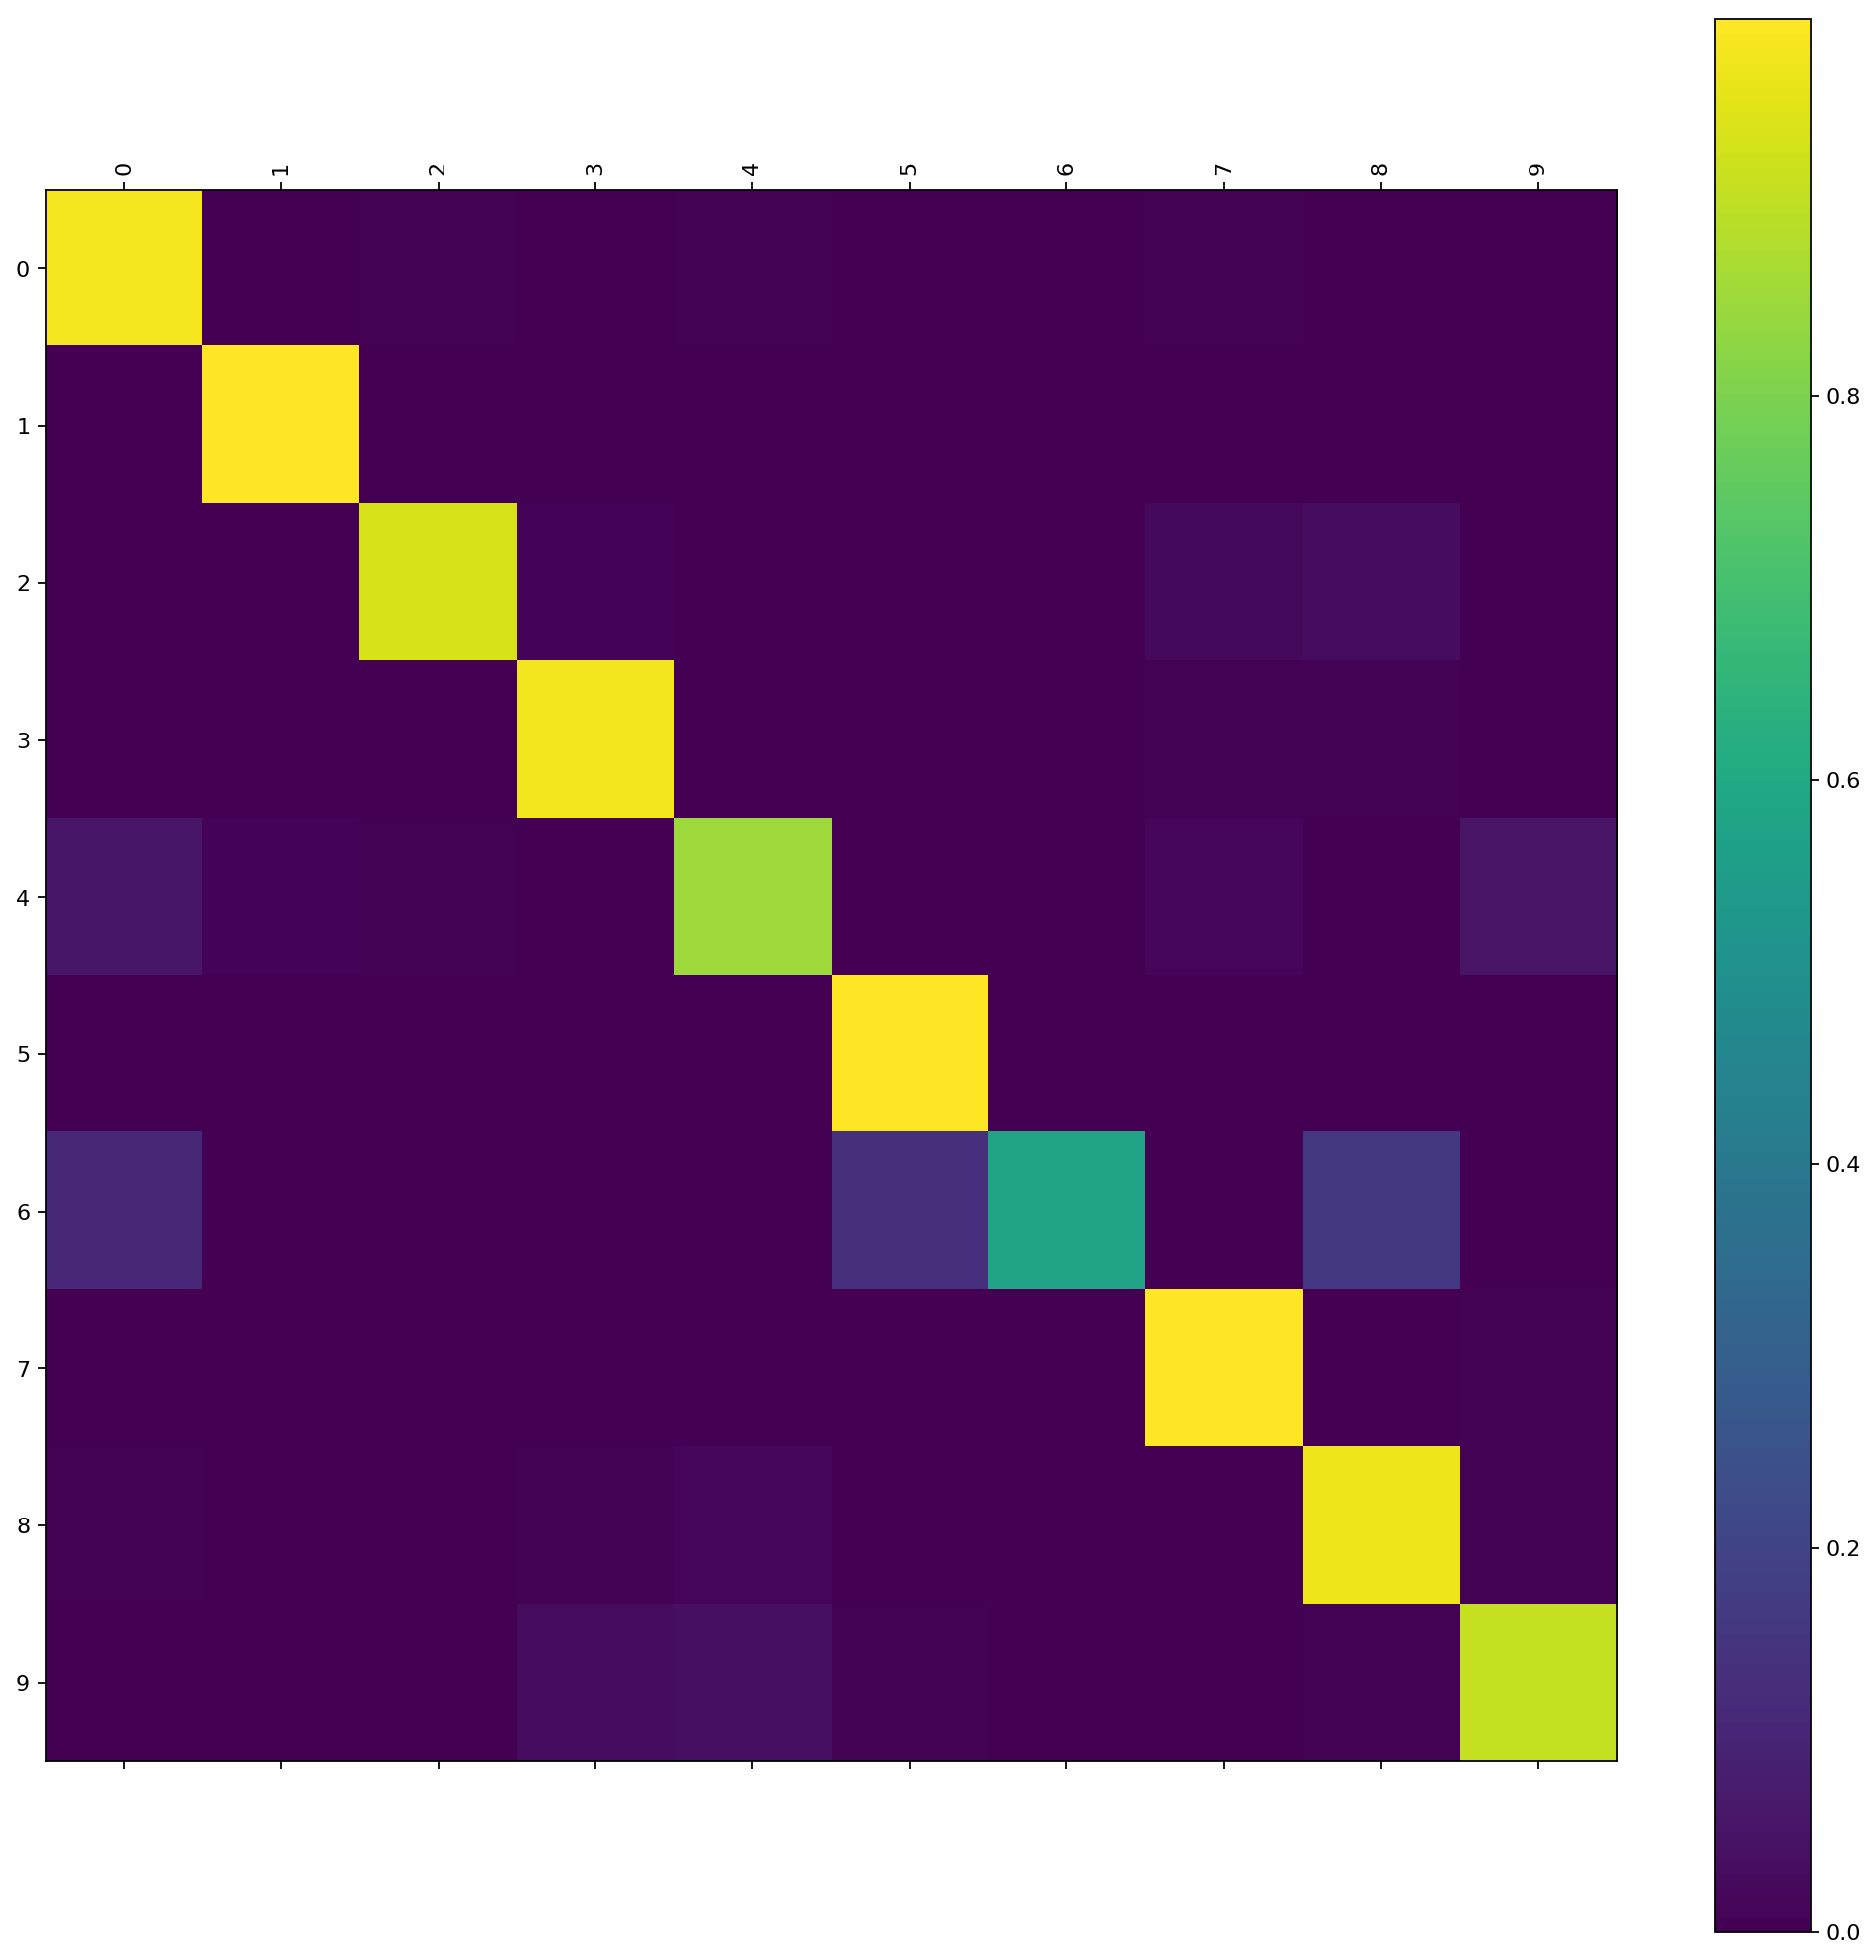

In [35]:
confusion_matrix(resnet_census_digit, loader_digit_test, digits)

In [33]:
accuracy_dict = accuracy_for_each_category(resnet_census_digit, loader_digit_test, digits)

In [34]:
for symbol, accuracy in sorted(accuracy_dict.items(), key = lambda p: p[1]):
    print('Symbol: {}, Acc: {:.4f}'.format(symbol, accuracy))

Symbol: 6, Acc: 0.5815
Symbol: 4, Acc: 0.8514
Symbol: 9, Acc: 0.9097
Symbol: 2, Acc: 0.9345
Symbol: 8, Acc: 0.9697
Symbol: 3, Acc: 0.9802
Symbol: 0, Acc: 0.9842
Symbol: 7, Acc: 0.9943
Symbol: 5, Acc: 0.9956
Symbol: 1, Acc: 0.9962


In [36]:
dset_mdigit = AdvancedImageFolder('mnistImages', transform, loader = greyscale_image_loader,
                                  shuffle = True)
loader_mdigit_train, loader_mdigit_test, loader_mdigit_validation = split_dataset(dset_mdigit, thread_count=8, batch_size=128)

In [37]:
resnet_mnist_digit = ResidualNet(1, 32, 32, 3, 10)
resnet_mnist_digit = nn.DataParallel(resnet_mnist_digit.cuda())

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer_digit = optim.SGD(resnet_mnist_digit.parameters(), lr=0.001, momentum=0.9)

In [39]:
resnet_mnist_digit = train_model_with_validation(resnet_mnist_digit, loader_mdigit_train, 
                                                 loader_mdigit_validation, criterion, 
                                                 optimizer_digit, exp_lr_scheduler)

Epoch 0/19
----------
LR is set to 0.001
Epoch Number: 0, Batch Number: 250, Loss: 0.0039, Acc: 0.8643
Time so far is 0m 3s
Epoch Number: 0, Validation Accuracy: 0.9619

Epoch 1/19
----------
Epoch Number: 1, Batch Number: 250, Loss: 0.0008, Acc: 0.9721
Time so far is 0m 9s
Epoch Number: 1, Validation Accuracy: 0.9723

Epoch 2/19
----------
Epoch Number: 2, Batch Number: 250, Loss: 0.0006, Acc: 0.9799
Time so far is 0m 15s
Epoch Number: 2, Validation Accuracy: 0.9786

Epoch 3/19
----------
Epoch Number: 3, Batch Number: 250, Loss: 0.0004, Acc: 0.9837
Time so far is 0m 22s
Epoch Number: 3, Validation Accuracy: 0.9813

Epoch 4/19
----------
Epoch Number: 4, Batch Number: 250, Loss: 0.0004, Acc: 0.9867
Time so far is 0m 28s
Epoch Number: 4, Validation Accuracy: 0.9818

Epoch 5/19
----------
Epoch Number: 5, Batch Number: 250, Loss: 0.0003, Acc: 0.9888
Time so far is 0m 34s
Epoch Number: 5, Validation Accuracy: 0.9825

Epoch 6/19
----------
Epoch Number: 6, Batch Number: 250, Loss: 0.0003,


 0.9554  0.0029  0.0029  0.0000  0.0129  0.0000  0.0014  0.0201  0.0029  0.0014
 0.0000  0.9839  0.0038  0.0000  0.0000  0.0009  0.0000  0.0104  0.0009  0.0000
 0.0000  0.0016  0.8396  0.0098  0.0000  0.0098  0.0000  0.0327  0.1064  0.0000
 0.0015  0.0031  0.0076  0.9573  0.0015  0.0046  0.0000  0.0153  0.0061  0.0031
 0.1038  0.0048  0.0304  0.0000  0.7396  0.0016  0.0000  0.0319  0.0016  0.0863
 0.0029  0.0015  0.0015  0.0015  0.0000  0.9897  0.0000  0.0015  0.0000  0.0015
 0.1679  0.0000  0.0000  0.0000  0.0063  0.2143  0.4912  0.0000  0.1053  0.0150
 0.0000  0.0014  0.0000  0.0000  0.0000  0.0000  0.0000  0.9971  0.0000  0.0014
 0.0173  0.0000  0.0022  0.0022  0.0390  0.0043  0.0000  0.0000  0.9156  0.0195
 0.0167  0.0000  0.0000  0.0611  0.0417  0.0264  0.0000  0.0042  0.0097  0.8403
[torch.FloatTensor of size 10x10]



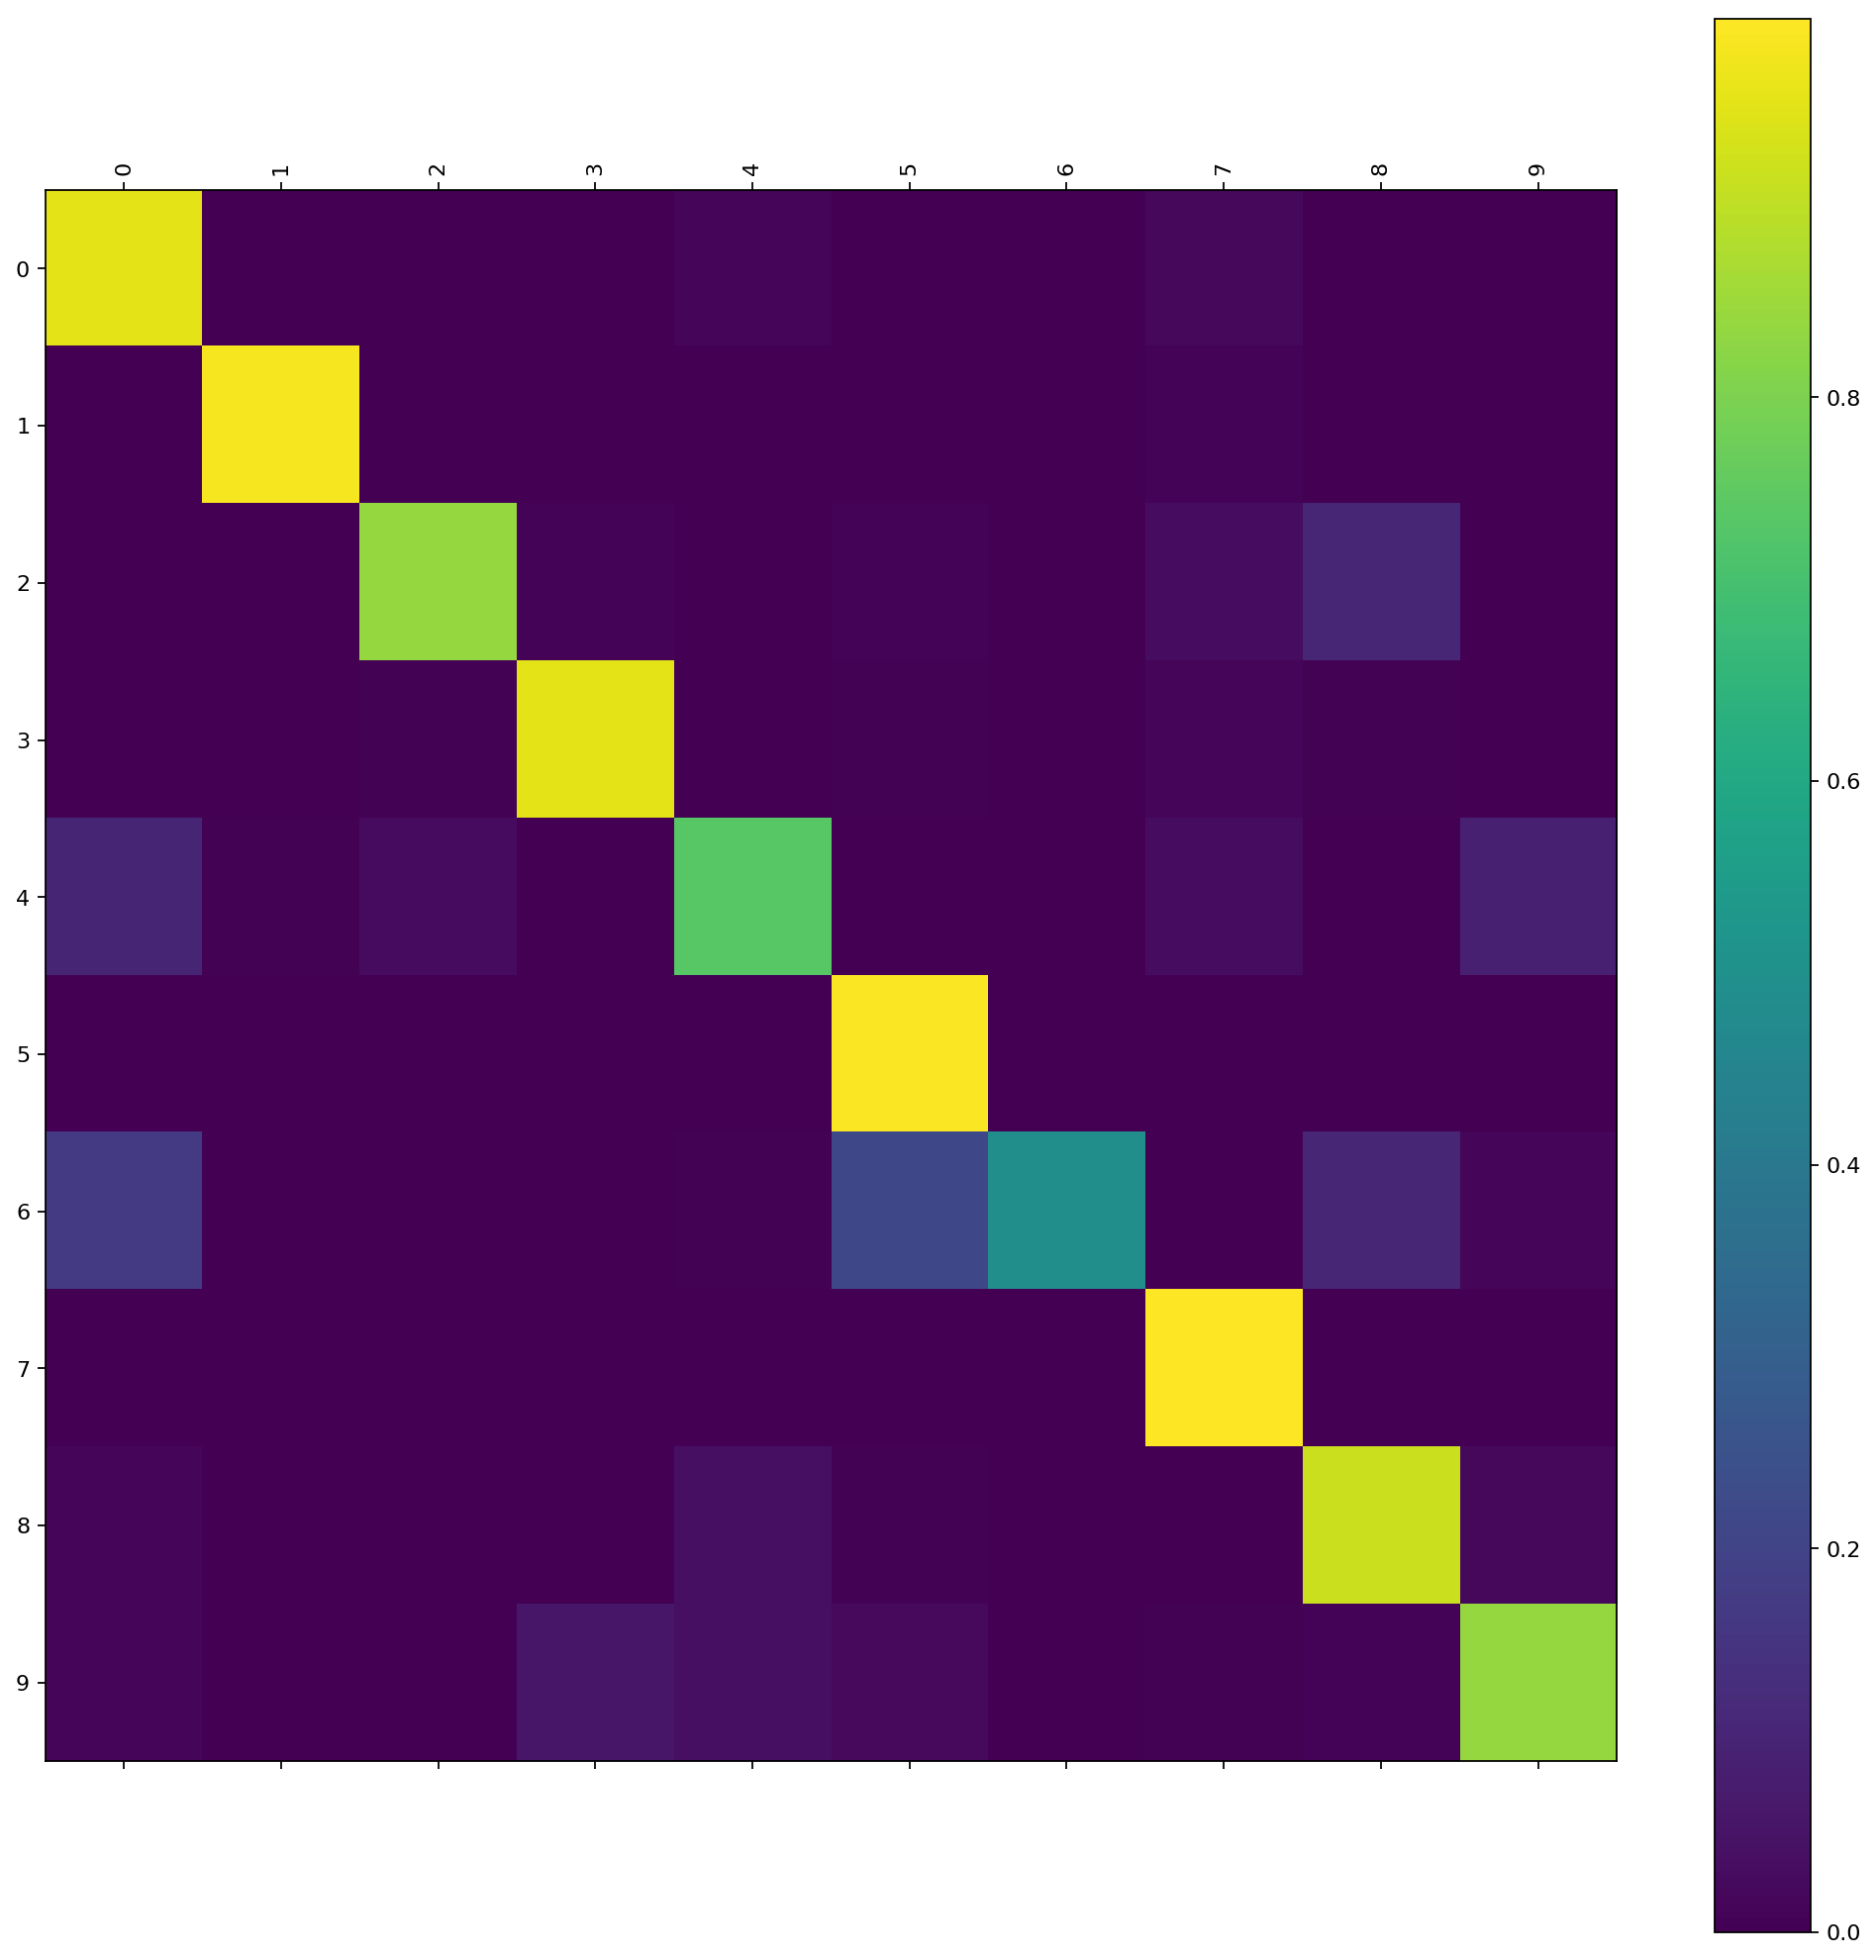

In [40]:
confusion_matrix(resnet_mnist_digit, loader_digit_test, digits)

In [41]:
accuracy_dict = accuracy_for_each_category(resnet_mnist_digit, loader_digit_test, digits)

In [42]:
for symbol, accuracy in sorted(accuracy_dict.items(), key = lambda p: p[1]):
    print('Symbol: {}, Acc: {:.4f}'.format(symbol, accuracy))

Symbol: 6, Acc: 0.4912
Symbol: 4, Acc: 0.7396
Symbol: 2, Acc: 0.8396
Symbol: 9, Acc: 0.8403
Symbol: 8, Acc: 0.9156
Symbol: 0, Acc: 0.9554
Symbol: 3, Acc: 0.9573
Symbol: 1, Acc: 0.9839
Symbol: 5, Acc: 0.9897
Symbol: 7, Acc: 0.9971


In [14]:
def test_model(model, dset_loader):
    model.train(False)
    
    running_corrects = 0
    
    for data in dset_loader:
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), \
                         Variable(labels.cuda())

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        running_corrects += torch.sum(preds == labels.data)
    
    return running_corrects/(len(dset_loader) * dset_loader.batch_size) 

In [44]:
print(test_model(resnet_sanborn_digit, loader_digit_test))
print(test_model(resnet_census_digit, loader_digit_test))
print(test_model(resnet_mnist_digit, loader_digit_test))

0.9815340909090909
0.9117897727272727
0.865625
